# Pytorch Starter for the PlantTraits2024 - FGVC11 Competition
This notebook provide a Pytorch Starter for the competition and is inspired by this [notebook](https://www.kaggle.com/code/awsaf49/planttraits2024-kerascv-starter-notebook)
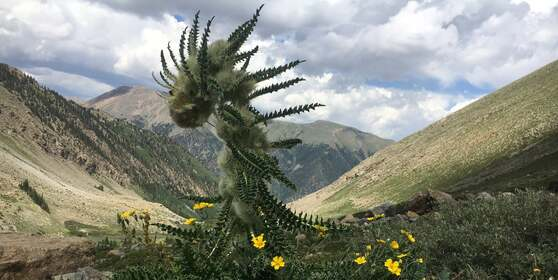

# 📚 | Import Libraries and Configurations

In [1]:
import os
import cv2
import torch
import joblib
import timm
import torch.nn as nn
import pandas as pd
import numpy as np
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchmetrics.regression import R2Score
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.models import vision_transformer


In [3]:
# Set a seed for PyTorch
seed_value = 42
torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)

# Set a seed for NumPy (if you're using NumPy alongside PyTorch)
np.random.seed(seed_value)

In [4]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    model_name = 'vit_base_patch16_384'#'maxvit_tiny_tf_384.in1k'  # Name of pretrained classifier
    image_size = 384  # Input image size
    epochs = 12 # Training epochs
    batch_size = 8  # Batch size
    lr = 1e-4
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    num_folds = 5 # Number of folds to split the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
    num_classes = len(class_names)
    aux_num_classes = len(aux_class_names)

In [5]:
BASE_PATH = "/kaggle/input/planttraits2024"

In [6]:
CFG.aux_class_names

['X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']

In [7]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, CFG.aux_class_names] = df.loc[:, CFG.aux_class_names].fillna(-1)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images/'+test_df['id'].astype(str)+'.jpeg'
FEATURE_COLS = test_df.columns[1:-1].tolist()
display(test_df.head(2))

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  192027691                               12.235703   
1  195542235                               17.270555   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            374.466675   
1                             90.239998   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                          62.524445                       
1                                          10.351111                       

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  72.256844   
1                                  38.220940   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                              773.592041   
1                              859.193298   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                33.277779                            125   
1                                40.009777                            124   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                                149                              136  ...   
1                                144                              138  ...   

   X26_mean  X50_mean  X3112_mean     X4_sd    X11_sd    X18_sd    X26_sd  \
0  1.243779  1.849375   50.216034  0.008921  1.601473  0.025441  0.153608   
1  0.642940  1.353468  574.098472  0.003102  0.258078  0.000866  0.034630   

     X50_sd   X3112_sd                                         image_path  
0  0.279610  15.045054  /kaggle/input/planttraits2024/train_images/192...  
1  0.010165  11.004477  /kaggle/input/planttraits2024/train_images/195...  

[2 rows x 177 columns]

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  201238668                                8.086756   
1  202310319                               10.844286   

   WORLDCLIM_BIO12_annual_precipitation  \
0                           2246.500000   
1                            495.871429   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                         127.321426                       
1                                          28.023809                       

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  20.423418   
1                                  18.738306   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                              353.381042   
1                              786.554382   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                17.535713                             80   
1                                29.292856                            130   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                                109                               90  ...   
1                                155                              142  ...   

   VOD_X_1997_2018_multiyear_mean_m04  VOD_X_1997_2018_multiyear_mean_m05  \
0                            0.389460                            0.387536   
1                            0.300813                            0.332776   

   VOD_X_1997_2018_multiyear_mean_m06  VOD_X_1997_2018_multiyear_mean_m07  \
0                            0.374910                            0.363712   
1                            0.314386                            0.291168   

   VOD_X_1997_2018_multiyear_mean_m08  VOD_X_1997_2018_multiyear_mean_m09  \
0                            0.364623                            0.379435   
1                            0.280947                            0.277623   

   VOD_X_1997_2018_multiyear_mean_m10  VOD_X_1997_2018_multiyear_mean_m11  \
0                            0.388294                            0.398887   
1                            0.276503                            0.271212   

   VOD_X_1997_2018_multiyear_mean_m12  \
0                            0.397853   
1                            0.272672   

                                          image_path  
0  /kaggle/input/planttraits2024/test_images/2012...  
1  /kaggle/input/planttraits2024/test_images/2023...  

[2 rows x 165 columns]

In [8]:
FEATURE_COLS = test_df.columns[1:-1].tolist()

# 🔬 | Dataset & DataLoader

The DataLoader efficiently manages the processing of JPEG images and tabular features as inputs, handling labels for both the main and auxiliary tasks simultaneously.

In [9]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PlantDataset(Dataset):
    def __init__(self, paths, features, labels=None, aux_labels=None, transform=None, augment=False):
        self.paths = paths
        self.features = features
        self.labels = labels
        self.aux_labels = aux_labels
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        feature = self.features[idx]

        # Read and decode image
        image = self.decode_image(path)

        # Apply augmentations
        if self.augment:
            augmented = self.transform(image=image)
            image = augmented['image']            
        else:
            # Ensure channel dimension is the first one
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float32)


        if self.labels is not None:
            label = torch.tensor(self.labels[idx])
            aux_label = torch.tensor(self.aux_labels[idx])
            return {'images': image, 'features': feature}, (label, aux_label)
        else:
            return {'images': image, 'features': feature}

    def decode_image(self, path):
        image = Image.open(path)
        image = image.resize((CFG.image_size,CFG.image_size))
        image = np.array(image)
        return image

def build_augmenter():
    # Define Albumentations augmentations
    transform = A.Compose([
        A.RandomBrightness(limit=0.1, always_apply=False, p=0.5),
        A.RandomContrast(limit=0.1, always_apply=False, p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.5),
        A.Cutout(num_holes=1, max_h_size=32, max_w_size=32, always_apply=False, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=5, p=0.5),
        ToTensorV2(),
    ])

    return transform

In [10]:
def build_dataset(paths, features, labels=None, aux_labels=None, batch_size=32, cache=True, augment=True, repeat=True, shuffle=1024, cache_dir="", drop_remainder=False):
    dataset = PlantDataset(paths, features, labels, aux_labels, transform=build_augmenter(), augment=augment)

    if cache_dir != "" and cache:
        os.makedirs(cache_dir, exist_ok=True)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4, drop_last=drop_remainder, pin_memory=True)

    return dataloader

In [11]:
from sklearn.model_selection import StratifiedKFold

# Assuming df is your dataframe containing file paths, features, labels, and fold information
skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=42)

# Create separate bin for each trait
for i, trait in enumerate(CFG.class_names):
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, CFG.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

df["final_bin"] = df[[f"bin_{i}" for i in range(len(CFG.class_names))]].astype(str).agg("".join, axis=1)

df["fold"] = -1  # Initialize fold column

# Perform the stratified split using final bin
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [12]:
# Sample from full data
sample_df = df.copy()
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_features = scaler.transform(valid_df[FEATURE_COLS].values)

# Num Train: 44391 | Num Valid: 11098


In [13]:
train_df

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0      192027691                               12.235703   
1      195542235                               17.270555   
3      195728812                               18.680834   
4      195251545                                0.673204   
5      195733955                               12.062123   
...          ...                                     ...   
55481  193145264                               15.907291   
55482  170161513                                7.772279   
55483  194246645                               10.237585   
55485  194523231                               13.724150   
55488  146608105                               24.559971   

       WORLDCLIM_BIO12_annual_precipitation  \
0                                374.466675   
1                                 90.239998   
3                               1473.933350   
4                                530.088867   
5                               1982.033325   
...                                     ...   
55481                           1166.500000   
55482                            842.102051   
55483                            746.724487   
55485                           1450.000000   
55488                           1748.857178   

       WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                              62.524445                       
1                                              10.351111                       
3                                             163.100006                       
4                                              50.857777                       
5                                             320.138092                       
...                                                  ...                       
55481                                         184.500000                       
55482                                          43.357143                       
55483                                          38.000000                       
55485                                         162.260208                       
55488                                         272.821442                       

       WORLDCLIM_BIO15_precipitation_seasonality  \
0                                      72.256844   
1                                      38.220940   
3                                      45.009758   
4                                      38.230709   
5                                      74.343796   
...                                          ...   
55481                                  72.396286   
55482                                  20.809752   
55483                                  17.433586   
55485                                  43.139324   
55488                                  51.363777   

       WORLDCLIM_BIO4_temperature_seasonality  \
0                                  773.592041   
1                                  859.193298   
3                                  381.053986   
4                                 1323.526855   
5                                  318.258270   
...                                       ...   
55481                              280.652466   
55482                              688.702271   
55483                              499.778442   
55485                              652.716858   
55488                               73.158348   

       WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                    33.277779                            125   
1                                    40.009777                            124   
3                                    20.436666                            120   
4                                    45.891998                             91   
5                                    17.557619                            101   
...                                        ...                     

In [14]:
# Extract file paths, features, labels, and fold information for train and validation sets
train_paths = train_df.image_path.values
train_labels = train_df[CFG.class_names].values
train_aux_labels = train_df[CFG.aux_class_names].values

valid_paths = valid_df.image_path.values
valid_labels = valid_df[CFG.class_names].values
valid_aux_labels = valid_df[CFG.aux_class_names].values

# Build datasets
train_dataloader = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=False)
valid_dataloader = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


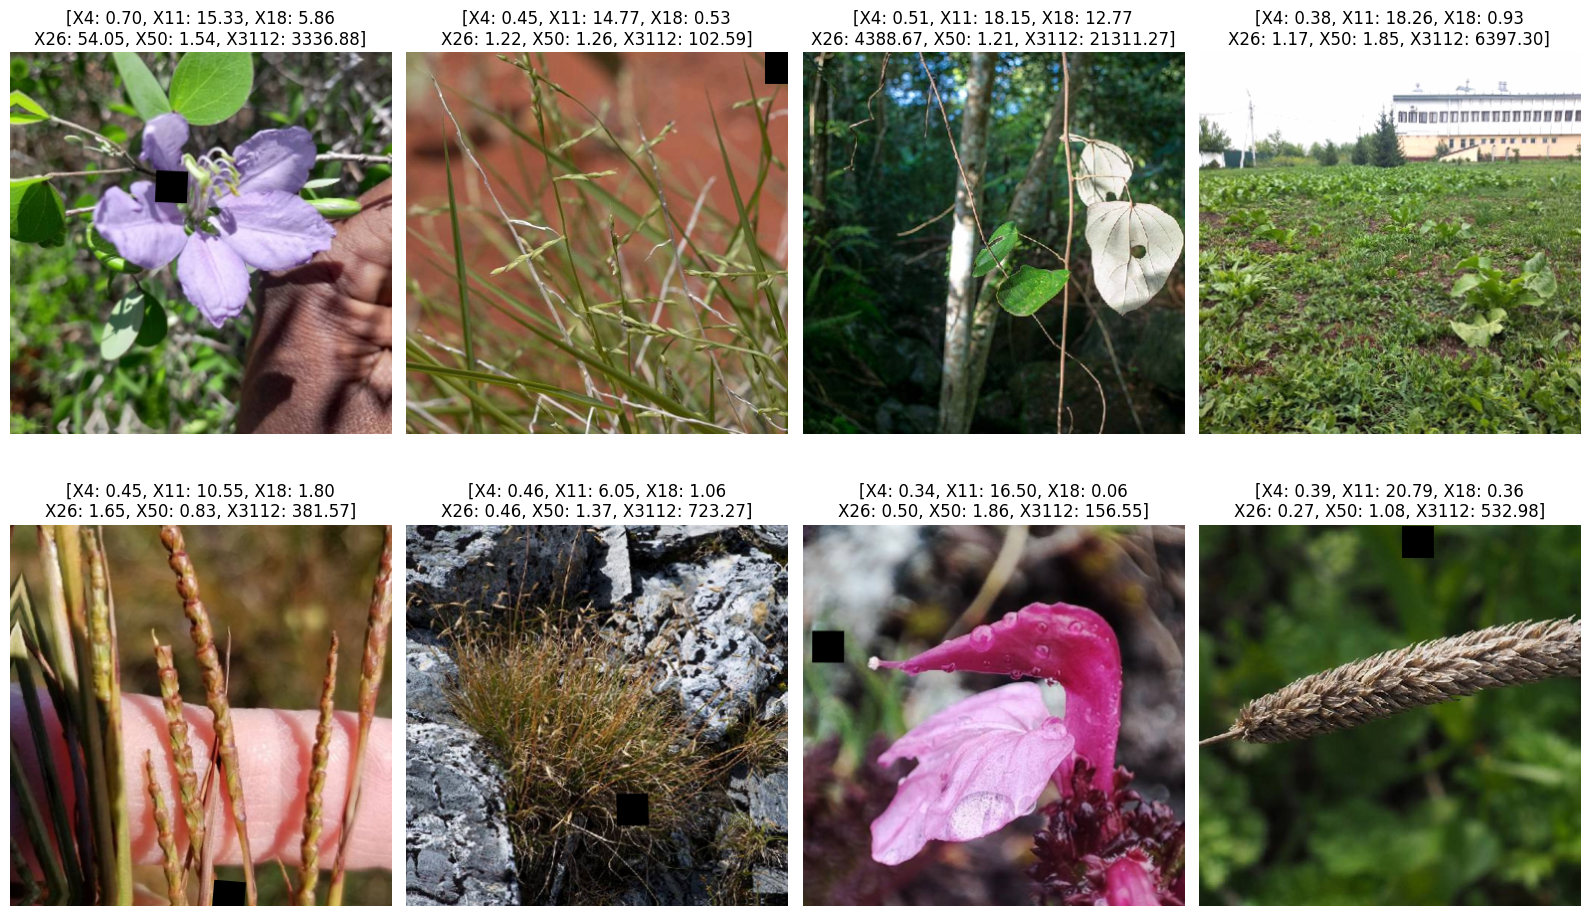

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of data
inps, tars = next(iter(train_dataloader))
imgs = inps["images"]
num_imgs, num_cols = 8, 4

# Convert PyTorch tensors to NumPy arrays
imgs_np = imgs.numpy()
tars_np = tars[0].numpy()

plt.figure(figsize=(4 * num_cols, num_imgs // num_cols * 5))

for i, (img, tar) in enumerate(zip(imgs_np[:num_imgs], tars_np[:num_imgs])):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)

    # Normalize the image to [0, 1]
    img = (img - img.min()) / (img.max() - img.min() + 1e-4)

    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(CFG.class_names[j : j + 3], tar[j : j + 3])
            )
            for j in range(0, len(CFG.class_names), 3)
        ]
    )

    plt.imshow(img.transpose(1, 2, 0))  # Transpose to (height, width, channels)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 🤖 | Modeling & Configuration

In [16]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [16]:
class CustomModel(nn.Module):
    def __init__(self, num_classes, aux_num_classes, feature_cols, model_name='vit_base_patch16_384'):
        super(CustomModel, self).__init__()

        # Define input layers
        self.img_input = nn.Identity()
        self.feat_input = nn.Identity()

        # Load pre-trained EfficientNetV2 model
        self.backbone = timm.create_model(model_name, pretrained=True)

        # Adapt the model to match the expected output size
        self.backbone.global_pool = nn.AdaptiveAvgPool2d(1)
        self.backbone.classifier = nn.Identity()

        self.dropout_img = nn.Dropout(0.2)

        # Branch for tabular/feature input
        self.dense1 = nn.Linear(len(feature_cols), 326)
        self.dense2 = nn.Linear(326, 64)
        self.dropout_feat = nn.Dropout(0.1)

        # Output layer
        self.head = nn.Linear(1064, num_classes)
        self.aux_head = nn.Linear(1064, aux_num_classes)

    def forward(self, img, feat):
        # Image branch
        x1 = self.backbone(img)
        x1 = self.dropout_img(x1.flatten(1))

        # Feature branch
        x2 = F.selu(self.dense1(self.feat_input(feat)))
        x2 = F.selu(self.dense2(x2))
        x2 = self.dropout_feat(x2)

        # Concatenate both branches
        concat = torch.cat([x1, x2], dim=1)
        # Output layer
        out1 = self.head(concat)
        out2 = F.relu(self.aux_head(concat))

        return {'head': out1, 'aux_head': out2}

In [17]:
# Instantiate the model with the desired EfficientNetV2 model_name
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomModel(CFG.num_classes, CFG.aux_num_classes, FEATURE_COLS, model_name=CFG.model_name)
model.to(device)
# Print the model summary
#print(model)

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

CustomModel(
  (img_input): Identity()
  (feat_input): Identity()
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=307

In [18]:
class R2Loss(nn.Module):
    def __init__(self, use_mask=False):
        super(R2Loss, self).__init__()
        self.use_mask = use_mask

    def forward(self, y_true, y_pred):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = torch.where(mask, y_true, torch.zeros_like(y_true))
            y_pred = torch.where(mask, y_pred, torch.zeros_like(y_pred))

        SS_res = torch.sum((y_true - y_pred)**2, dim=0)  # (B, C) -> (C,)
        SS_tot = torch.sum((y_true - torch.mean(y_true, dim=0))**2, dim=0)  # (B, C) -> (C,)
        r2_loss = SS_res / (SS_tot + 1e-6)  # (C,)
        return torch.mean(r2_loss)  # ()

class R2Metric(nn.Module):
    def __init__(self, num_classes=6):
        super(R2Metric, self).__init__()
        self.num_classes = num_classes
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.reset()

    def reset(self):
        self.SS_res = torch.zeros(self.num_classes, device=self.device)
        self.SS_tot = torch.zeros(self.num_classes, device=self.device)
        self.num_samples = torch.tensor(0, dtype=torch.float32, device=self.device)

    def forward(self, y_true, y_pred):
        y_true = y_true.to(self.device)
        y_pred = y_pred.to(self.device)

        SS_res = torch.sum((y_true - y_pred)**2, dim=0)
        SS_tot = torch.sum((y_true - torch.mean(y_true, dim=0))**2, dim=0)
        self.SS_res += SS_res
        self.SS_tot += SS_tot
        self.num_samples += y_true.size(0)

    def compute(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return torch.mean(r2)

In [19]:
def get_lr_scheduler(optimizer, dataloader, epochs, max_lr, steps_per_epoch, pct_start=0.3, div_factor=25.0, final_div_factor=1e4):
    total_steps = steps_per_epoch * epochs
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=pct_start, div_factor=div_factor, final_div_factor=final_div_factor)

    def lr_lambda(step):
        return scheduler.get_lr()

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [20]:
# Define loss functions and metrics
criterion_head = R2Loss(use_mask=False)
criterion_aux_head = R2Loss(use_mask=True)

# Loss weights
weight_head = 1.0
weight_aux_head = 0.3

# Model checkpoint
best_model_path = "best_model.pth"
best_r2_score = -float('inf')
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)

In [21]:
import torch
import torch.optim as optim
from torchmetrics.regression import R2Score
from tqdm import tqdm

# Assuming that you have already defined your model, dataloaders, and other necessary configurations

# Initialize the R2Score metric
metric_head = R2Score(num_outputs=6, multioutput='uniform_average').to(device)

# Training loop
for epoch in range(CFG.epochs):
    # Training
    model.train()
    total_train_r2 = 0.0
    train_batches = 0

    for batch_idx, (inputs_dict, (targets, aux_targets)) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        # Move data to GPU
        inputs_images = inputs_dict['images'].to(device, dtype=torch.float32)
        inputs_features = inputs_dict['features'].to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)
        aux_targets = aux_targets.to(device, dtype=torch.float32)

        # Forward pass
        outputs = model(inputs_images, inputs_features)

        # Compute losses
        loss_head = weight_head * criterion_head(outputs['head'], targets)
        loss_aux_head = weight_aux_head * criterion_aux_head(outputs['aux_head'], aux_targets)
        loss = loss_head + loss_aux_head

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the R2 metric
        r2_value = metric_head(outputs['head'], targets)
        total_train_r2 += r2_value.item()
        train_batches += 1

    # Compute the average training R2 score
    avg_train_r2 = total_train_r2 / train_batches
    print(f"Epoch {epoch + 1}/{CFG.epochs}, Average Train R2 Score: {avg_train_r2}")

    # Validation
    model.eval()
    total_val_r2 = 0.0
    val_batches = 0

    with torch.no_grad():
        for val_batch_idx, (val_inputs_dict, (val_targets, val_aux_targets)) in enumerate(tqdm(valid_dataloader)):
            val_inputs_images = val_inputs_dict['images'].to(device, dtype=torch.float32)
            val_inputs_features = val_inputs_dict['features'].to(device, dtype=torch.float32)
            val_targets = val_targets.to(device, dtype=torch.float32)
            val_aux_targets = val_aux_targets.to(device, dtype=torch.float32)

            val_outputs = model(val_inputs_images, val_inputs_features)

            # Compute the R2 metric for validation
            r2_value = metric_head(val_outputs['head'], val_targets)
            total_val_r2 += r2_value.item()
            val_batches += 1

    # Compute the average validation R2 score
    avg_val_r2 = total_val_r2 / val_batches
    print(f"Epoch {epoch + 1}/{CFG.epochs}, Average Val R2 Score: {avg_val_r2}")

    # Save the best model based on validation R2 score
    if avg_val_r2 > best_r2_score:
        best_r2_score = avg_val_r2
        torch.save(model.state_dict(), best_model_path)

100%|██████████| 5549/5549 [47:00<00:00,  1.97it/s]


Epoch 1/12, Average Train R2 Score: -644.2346521560019


100%|██████████| 1388/1388 [03:27<00:00,  6.68it/s]


Epoch 1/12, Average Val R2 Score: -1114.1662768816054


100%|██████████| 5549/5549 [47:05<00:00,  1.96it/s]


Epoch 2/12, Average Train R2 Score: -1396.1440147728636


100%|██████████| 1388/1388 [03:27<00:00,  6.70it/s]


Epoch 2/12, Average Val R2 Score: -2750.8333655200704


100%|██████████| 5549/5549 [47:05<00:00,  1.96it/s]


Epoch 3/12, Average Train R2 Score: -5098.225639066217


100%|██████████| 1388/1388 [03:27<00:00,  6.70it/s]


Epoch 3/12, Average Val R2 Score: -5484.60768944798


100%|██████████| 5549/5549 [47:07<00:00,  1.96it/s]


Epoch 4/12, Average Train R2 Score: -5189.070709970625


100%|██████████| 1388/1388 [03:26<00:00,  6.71it/s]


Epoch 4/12, Average Val R2 Score: -3105.9159751872853


100%|██████████| 5549/5549 [47:08<00:00,  1.96it/s]


Epoch 5/12, Average Train R2 Score: -6618.452560166493


100%|██████████| 1388/1388 [03:26<00:00,  6.71it/s]


Epoch 5/12, Average Val R2 Score: -1553.5792233442367


100%|██████████| 5549/5549 [47:08<00:00,  1.96it/s]


Epoch 6/12, Average Train R2 Score: -28783.245845227182


100%|██████████| 1388/1388 [03:26<00:00,  6.72it/s]


Epoch 6/12, Average Val R2 Score: -65589.1115130004


100%|██████████| 5549/5549 [47:06<00:00,  1.96it/s]


Epoch 7/12, Average Train R2 Score: -59905.28398377059


100%|██████████| 1388/1388 [03:26<00:00,  6.73it/s]


Epoch 7/12, Average Val R2 Score: -59195.70465070301


100%|██████████| 5549/5549 [47:03<00:00,  1.97it/s]


Epoch 8/12, Average Train R2 Score: -47455.987021499335


100%|██████████| 1388/1388 [03:26<00:00,  6.72it/s]


Epoch 8/12, Average Val R2 Score: -6957.176345399203


100%|██████████| 5549/5549 [47:02<00:00,  1.97it/s]


Epoch 9/12, Average Train R2 Score: -40144.84070336924


100%|██████████| 1388/1388 [03:26<00:00,  6.73it/s]


Epoch 9/12, Average Val R2 Score: -100926.33593754398


100%|██████████| 5549/5549 [47:03<00:00,  1.97it/s]


Epoch 10/12, Average Train R2 Score: -52521.44624923951


100%|██████████| 1388/1388 [03:26<00:00,  6.73it/s]


Epoch 10/12, Average Val R2 Score: -166512.96847257146


100%|██████████| 5549/5549 [47:02<00:00,  1.97it/s]


Epoch 11/12, Average Train R2 Score: -130634.19752643508


100%|██████████| 1388/1388 [03:26<00:00,  6.73it/s]


Epoch 11/12, Average Val R2 Score: -287798.5943047691


100%|██████████| 5549/5549 [47:02<00:00,  1.97it/s]


Epoch 12/12, Average Train R2 Score: -192138.12001496545


100%|██████████| 1388/1388 [03:25<00:00,  6.74it/s]

Epoch 12/12, Average Val R2 Score: -34509.737825685


In [1]:
model.load_state_dict(torch.load(best_model_path))

NameError: name 'model' is not defined

In [ ]:
# Test
test_paths = test_df.image_path.values
test_features = scaler.transform(test_df[FEATURE_COLS].values) 
test_ds = build_dataset(test_paths, test_features, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

# 👨‍🔬 | Submission

In [ ]:
model.eval()  # Set the model to evaluation mode

# List to store predictions
all_predictions = []

# Iterate over batches in the test data loader
for batch_idx, inputs_dict in enumerate(tqdm(test_ds, desc='Testing')):
    # Extract images and features from the inputs_dict
    inputs_images = inputs_dict['images'].to(device, dtype=torch.float32)  # Assuming 'device' is the target device
    inputs_features = inputs_dict['features'].to(device, dtype=torch.float32)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs_images, inputs_features)

    # Get predictions
    predictions = outputs['head'].cpu().numpy()  # Assuming 'head' is the main task output

    # Append predictions to the list
    all_predictions.append(predictions)

# Concatenate predictions for all batches
all_predictions = np.concatenate(all_predictions, axis=0)

In [ ]:
pred_df = test_df[["id"]].copy()
target_cols = [x.replace("_mean","") for x in CFG.class_names]
pred_df[target_cols] = all_predictions.tolist()

In [ ]:
sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["id"]].copy()
sub_df = sub_df.merge(pred_df, on="id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()